In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.


In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla T4)


In [ ]:
%cd mmsegmentation

/content/mmsegmentation


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-05-17 12:48:49--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  7.74MB/s    in 37s     

2022-05-17 12:49:27 (8.36 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building')
palette = [[0, 0, 0], [128, 128, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2

cfg.model.decode_head.loss_decode = dict(type='DiceLoss', loss_weight = 1.0)

In [ ]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
#cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [ ]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [ ]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(type='DiceLoss', loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='slide',

### 모델 학습

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-17 12:49:29,175 - mmseg - INFO - Loaded 537 images
2022-05-17 12:49:34,115 - mmseg - INFO - Loaded 113 images
2022-05-17 12:49:34,119 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-17 12:49:34,587 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
2022-05-17 12:49:34,594 - mmseg - INFO - Start running, host: root@b62a6a877127, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1
2022-05-17 12:49:34,595 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VER

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 824s, ETA:     0s

2022-05-17 13:30:44,186 - mmseg - INFO - per class results:
2022-05-17 13:30:44,187 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.75 | 92.19 |
|  building  | 76.86 | 89.41 |
+------------+-------+-------+
2022-05-17 13:30:44,189 - mmseg - INFO - Summary:
2022-05-17 13:30:44,190 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 91.29 | 82.31 | 90.8 |
+-------+-------+------+
2022-05-17 13:30:44,192 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9129, mIoU: 0.8231, mAcc: 0.9080, IoU.background: 0.8775, IoU.building: 0.7686, Acc.background: 0.9219, Acc.building: 0.8941
2022-05-17 13:33:18,704 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 12:31:25, time: 9.784, data_time: 8.269, memory: 12951, decode.loss_dice: 0.1884, decode.acc_seg: 89.7434, loss: 0.1884
2022-05-17 13:35:50,738 - mmseg - INFO - Iter [1200/20000]	lr: 4.508e-05, eta: 12:04:51, time: 1.520, data

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 719s, ETA:     0s

2022-05-17 14:08:17,082 - mmseg - INFO - per class results:
2022-05-17 14:08:17,084 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.68 | 94.02 |
|  building  | 79.89 | 89.88 |
+------------+-------+-------+
2022-05-17 14:08:17,085 - mmseg - INFO - Summary:
2022-05-17 14:08:17,088 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.68 | 84.78 | 91.95 |
+-------+-------+-------+
2022-05-17 14:08:17,090 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9268, mIoU: 0.8478, mAcc: 0.9195, IoU.background: 0.8968, IoU.building: 0.7989, Acc.background: 0.9402, Acc.building: 0.8988
2022-05-17 14:10:49,189 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 11:32:29, time: 8.715, data_time: 7.201, memory: 12951, decode.loss_dice: 0.1594, decode.acc_seg: 92.3470, loss: 0.1594
2022-05-17 14:13:23,629 - mmseg - INFO - Iter [2200/20000]	lr: 5.340e-05, eta: 11:18:08, time: 1.544,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 720s, ETA:     0s

2022-05-17 14:45:48,182 - mmseg - INFO - per class results:
2022-05-17 14:45:48,184 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.38 |  95.2 |
|  building  | 80.74 | 88.86 |
+------------+-------+-------+
2022-05-17 14:45:48,185 - mmseg - INFO - Summary:
2022-05-17 14:45:48,188 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.14 | 85.56 | 92.03 |
+-------+-------+-------+
2022-05-17 14:45:48,190 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9314, mIoU: 0.8556, mAcc: 0.9203, IoU.background: 0.9038, IoU.building: 0.8074, Acc.background: 0.9520, Acc.building: 0.8886
2022-05-17 14:48:20,469 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 10:47:27, time: 8.719, data_time: 7.203, memory: 12951, decode.loss_dice: 0.1433, decode.acc_seg: 92.7474, loss: 0.1433
2022-05-17 14:50:52,685 - mmseg - INFO - Iter [3200/20000]	lr: 5.040e-05, eta: 10:36:49, time: 1.522,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 719s, ETA:     0s

2022-05-17 15:23:22,205 - mmseg - INFO - per class results:
2022-05-17 15:23:22,207 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.72 | 95.34 |
|  building  | 81.43 | 89.37 |
+------------+-------+-------+
2022-05-17 15:23:22,208 - mmseg - INFO - Summary:
2022-05-17 15:23:22,210 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.41 | 86.08 | 92.35 |
+-------+-------+-------+
2022-05-17 15:23:22,212 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9341, mIoU: 0.8608, mAcc: 0.9235, IoU.background: 0.9072, IoU.building: 0.8143, Acc.background: 0.9534, Acc.building: 0.8937
2022-05-17 15:25:54,520 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 10:06:15, time: 8.717, data_time: 7.202, memory: 12951, decode.loss_dice: 0.1377, decode.acc_seg: 93.3505, loss: 0.1377
2022-05-17 15:28:26,604 - mmseg - INFO - Iter [4200/20000]	lr: 4.740e-05, eta: 9:57:38, time: 1.521, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 718s, ETA:     0s

2022-05-17 16:00:51,834 - mmseg - INFO - per class results:
2022-05-17 16:00:51,836 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.05 | 95.47 |
|  building  | 82.06 | 89.83 |
+------------+-------+-------+
2022-05-17 16:00:51,836 - mmseg - INFO - Summary:
2022-05-17 16:00:51,839 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.65 | 86.56 | 92.65 |
+-------+-------+-------+
2022-05-17 16:00:51,840 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9365, mIoU: 0.8656, mAcc: 0.9265, IoU.background: 0.9105, IoU.building: 0.8206, Acc.background: 0.9547, Acc.building: 0.8983
2022-05-17 16:03:23,970 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 9:26:15, time: 8.706, data_time: 7.192, memory: 12951, decode.loss_dice: 0.1581, decode.acc_seg: 93.2616, loss: 0.1581
2022-05-17 16:05:56,107 - mmseg - INFO - Iter [5200/20000]	lr: 4.440e-05, eta: 9:18:51, time: 1.521, d

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 719s, ETA:     0s

2022-05-17 16:38:21,520 - mmseg - INFO - per class results:
2022-05-17 16:38:21,521 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.45 | 94.16 |
|  building  | 81.47 | 91.42 |
+------------+-------+-------+
2022-05-17 16:38:21,522 - mmseg - INFO - Summary:
2022-05-17 16:38:21,525 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.27 | 85.96 | 92.79 |
+-------+-------+-------+
2022-05-17 16:38:21,526 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9327, mIoU: 0.8596, mAcc: 0.9279, IoU.background: 0.9045, IoU.building: 0.8147, Acc.background: 0.9416, Acc.building: 0.9142
2022-05-17 16:40:53,668 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 8:47:05, time: 8.713, data_time: 7.199, memory: 12951, decode.loss_dice: 0.1833, decode.acc_seg: 92.7378, loss: 0.1833
2022-05-17 16:43:25,682 - mmseg - INFO - Iter [6200/20000]	lr: 4.140e-05, eta: 8:40:30, time: 1.520, d

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 720s, ETA:     0s

2022-05-17 17:15:52,019 - mmseg - INFO - per class results:
2022-05-17 17:15:52,020 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.34 | 95.84 |
|  building  | 82.51 | 89.68 |
+------------+-------+-------+
2022-05-17 17:15:52,024 - mmseg - INFO - Summary:
2022-05-17 17:15:52,025 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.85 | 86.92 | 92.76 |
+-------+-------+-------+
2022-05-17 17:15:52,029 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9385, mIoU: 0.8692, mAcc: 0.9276, IoU.background: 0.9134, IoU.building: 0.8251, Acc.background: 0.9584, Acc.building: 0.8968
2022-05-17 17:18:24,109 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 8:08:25, time: 8.718, data_time: 7.205, memory: 12951, decode.loss_dice: 0.1840, decode.acc_seg: 93.0143, loss: 0.1840
2022-05-17 17:20:56,322 - mmseg - INFO - Iter [7200/20000]	lr: 3.840e-05, eta: 8:02:25, time: 1.522, d

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 720s, ETA:     0s

2022-05-17 17:53:22,334 - mmseg - INFO - per class results:
2022-05-17 17:53:22,335 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.14 | 94.68 |
|  building  | 82.68 | 91.89 |
+------------+-------+-------+
2022-05-17 17:53:22,336 - mmseg - INFO - Summary:
2022-05-17 17:53:22,339 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.77 | 86.91 | 93.28 |
+-------+-------+-------+
2022-05-17 17:53:22,340 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9377, mIoU: 0.8691, mAcc: 0.9328, IoU.background: 0.9114, IoU.building: 0.8268, Acc.background: 0.9468, Acc.building: 0.9189
2022-05-17 17:55:56,768 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 7:30:05, time: 8.742, data_time: 7.227, memory: 12951, decode.loss_dice: 0.1511, decode.acc_seg: 93.6894, loss: 0.1511
2022-05-17 17:58:28,917 - mmseg - INFO - Iter [8200/20000]	lr: 3.540e-05, eta: 7:24:31, time: 1.521, d

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 720s, ETA:     0s

2022-05-17 18:30:54,590 - mmseg - INFO - per class results:
2022-05-17 18:30:54,593 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.27 | 95.56 |
|  building  | 82.51 | 90.17 |
+------------+-------+-------+
2022-05-17 18:30:54,595 - mmseg - INFO - Summary:
2022-05-17 18:30:54,599 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.82 | 86.89 | 92.86 |
+-------+-------+-------+
2022-05-17 18:30:54,601 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9382, mIoU: 0.8689, mAcc: 0.9286, IoU.background: 0.9127, IoU.building: 0.8251, Acc.background: 0.9556, Acc.building: 0.9017
2022-05-17 18:33:26,969 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 6:51:53, time: 8.725, data_time: 7.209, memory: 12951, decode.loss_dice: 0.1468, decode.acc_seg: 94.0579, loss: 0.1468
2022-05-17 18:36:01,536 - mmseg - INFO - Iter [9200/20000]	lr: 3.240e-05, eta: 6:46:41, time: 1.546, d

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 720s, ETA:     0s

2022-05-17 19:08:28,236 - mmseg - INFO - per class results:
2022-05-17 19:08:28,237 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  91.0 | 96.03 |
|  building  | 81.67 | 88.45 |
+------------+-------+-------+
2022-05-17 19:08:28,238 - mmseg - INFO - Summary:
2022-05-17 19:08:28,240 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.58 | 86.33 | 92.24 |
+-------+-------+-------+
2022-05-17 19:08:28,242 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9358, mIoU: 0.8633, mAcc: 0.9224, IoU.background: 0.9100, IoU.building: 0.8167, Acc.background: 0.9603, Acc.building: 0.8845
2022-05-17 19:11:00,501 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 6:13:52, time: 8.726, data_time: 7.211, memory: 12951, decode.loss_dice: 0.1671, decode.acc_seg: 93.6898, loss: 0.1671
2022-05-17 19:13:32,859 - mmseg - INFO - Iter [10200/20000]	lr: 2.940e-05, eta: 6:08:54, time: 1.524,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 720s, ETA:     0s

2022-05-17 19:46:01,236 - mmseg - INFO - per class results:
2022-05-17 19:46:01,237 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.63 | 95.55 |
|  building  |  83.3 | 91.06 |
+------------+-------+-------+
2022-05-17 19:46:01,239 - mmseg - INFO - Summary:
2022-05-17 19:46:01,242 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 94.09 | 87.47 | 93.3 |
+-------+-------+------+
2022-05-17 19:46:01,244 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9409, mIoU: 0.8747, mAcc: 0.9330, IoU.background: 0.9163, IoU.building: 0.8330, Acc.background: 0.9555, Acc.building: 0.9106
2022-05-17 19:48:33,557 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 5:35:56, time: 8.725, data_time: 7.210, memory: 12951, decode.loss_dice: 0.1287, decode.acc_seg: 94.7249, loss: 0.1287
2022-05-17 19:51:05,912 - mmseg - INFO - Iter [11200/20000]	lr: 2.640e-05, eta: 5:31:11, time: 1.524, data

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 721s, ETA:     0s

2022-05-17 20:23:36,360 - mmseg - INFO - per class results:
2022-05-17 20:23:36,362 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.48 | 95.31 |
|  building  |  83.1 | 91.24 |
+------------+-------+-------+
2022-05-17 20:23:36,363 - mmseg - INFO - Summary:
2022-05-17 20:23:36,367 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 94.0 | 87.29 | 93.28 |
+------+-------+-------+
2022-05-17 20:23:36,369 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9400, mIoU: 0.8729, mAcc: 0.9328, IoU.background: 0.9148, IoU.building: 0.8310, Acc.background: 0.9531, Acc.building: 0.9124
2022-05-17 20:26:08,605 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 4:58:05, time: 8.734, data_time: 7.219, memory: 12951, decode.loss_dice: 0.1331, decode.acc_seg: 94.9095, loss: 0.1331
2022-05-17 20:28:41,018 - mmseg - INFO - Iter [12200/20000]	lr: 2.340e-05, eta: 4:53:31, time: 1.524, data

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 721s, ETA:     0s

2022-05-17 21:01:10,056 - mmseg - INFO - per class results:
2022-05-17 21:01:10,058 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.78 | 95.49 |
|  building  | 83.67 | 91.56 |
+------------+-------+-------+
2022-05-17 21:01:10,060 - mmseg - INFO - Summary:
2022-05-17 21:01:10,062 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.22 | 87.73 | 93.52 |
+-------+-------+-------+
2022-05-17 21:01:10,065 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9422, mIoU: 0.8773, mAcc: 0.9352, IoU.background: 0.9178, IoU.building: 0.8367, Acc.background: 0.9549, Acc.building: 0.9156
2022-05-17 21:03:42,361 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 4:20:15, time: 8.733, data_time: 7.218, memory: 12951, decode.loss_dice: 0.1639, decode.acc_seg: 94.5902, loss: 0.1639
2022-05-17 21:06:14,785 - mmseg - INFO - Iter [13200/20000]	lr: 2.040e-05, eta: 4:15:51, time: 1.524,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 721s, ETA:     0s

2022-05-17 21:38:45,499 - mmseg - INFO - per class results:
2022-05-17 21:38:45,500 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.55 | 94.93 |
|  building  | 83.44 | 92.28 |
+------------+-------+-------+
2022-05-17 21:38:45,501 - mmseg - INFO - Summary:
2022-05-17 21:38:45,503 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 94.08 | 87.5 | 93.61 |
+-------+------+-------+
2022-05-17 21:38:45,504 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9408, mIoU: 0.8750, mAcc: 0.9361, IoU.background: 0.9155, IoU.building: 0.8344, Acc.background: 0.9493, Acc.building: 0.9228
2022-05-17 21:41:17,946 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 3:42:29, time: 8.730, data_time: 7.214, memory: 12951, decode.loss_dice: 0.1029, decode.acc_seg: 95.0397, loss: 0.1029
2022-05-17 21:43:50,321 - mmseg - INFO - Iter [14200/20000]	lr: 1.740e-05, eta: 3:38:13, time: 1.524, data

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 720s, ETA:     0s

2022-05-17 22:16:17,623 - mmseg - INFO - per class results:
2022-05-17 22:16:17,625 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.73 | 95.84 |
|  building  | 83.39 | 90.63 |
+------------+-------+-------+
2022-05-17 22:16:17,626 - mmseg - INFO - Summary:
2022-05-17 22:16:17,629 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.16 | 87.56 | 93.24 |
+-------+-------+-------+
2022-05-17 22:16:17,631 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9416, mIoU: 0.8756, mAcc: 0.9324, IoU.background: 0.9173, IoU.building: 0.8339, Acc.background: 0.9584, Acc.building: 0.9063
2022-05-17 22:18:52,094 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 3:04:44, time: 8.748, data_time: 7.232, memory: 12951, decode.loss_dice: 0.1858, decode.acc_seg: 94.5169, loss: 0.1858
2022-05-17 22:21:24,482 - mmseg - INFO - Iter [15200/20000]	lr: 1.440e-05, eta: 3:00:34, time: 1.524,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 720s, ETA:     0s

2022-05-17 22:53:51,860 - mmseg - INFO - per class results:
2022-05-17 22:53:51,861 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.61 | 94.99 |
|  building  | 83.54 | 92.29 |
+------------+-------+-------+
2022-05-17 22:53:51,862 - mmseg - INFO - Summary:
2022-05-17 22:53:51,863 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.11 | 87.57 | 93.64 |
+-------+-------+-------+
2022-05-17 22:53:51,866 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9411, mIoU: 0.8757, mAcc: 0.9364, IoU.background: 0.9161, IoU.building: 0.8354, Acc.background: 0.9499, Acc.building: 0.9229
2022-05-17 22:56:24,306 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 2:26:59, time: 8.728, data_time: 7.211, memory: 12951, decode.loss_dice: 0.1225, decode.acc_seg: 95.0293, loss: 0.1225
2022-05-17 22:58:58,822 - mmseg - INFO - Iter [16200/20000]	lr: 1.140e-05, eta: 2:22:56, time: 1.545,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 720s, ETA:     0s

2022-05-17 23:31:25,183 - mmseg - INFO - per class results:
2022-05-17 23:31:25,184 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.83 | 95.43 |
|  building  | 83.79 | 91.81 |
+------------+-------+-------+
2022-05-17 23:31:25,188 - mmseg - INFO - Summary:
2022-05-17 23:31:25,190 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.26 | 87.81 | 93.62 |
+-------+-------+-------+
2022-05-17 23:31:25,191 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9426, mIoU: 0.8781, mAcc: 0.9362, IoU.background: 0.9183, IoU.building: 0.8379, Acc.background: 0.9543, Acc.building: 0.9181
2022-05-17 23:33:57,568 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 1:49:16, time: 8.722, data_time: 7.206, memory: 12951, decode.loss_dice: 0.1372, decode.acc_seg: 95.1587, loss: 0.1372
2022-05-17 23:36:32,232 - mmseg - INFO - Iter [17200/20000]	lr: 8.403e-06, eta: 1:45:19, time: 1.547,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 721s, ETA:     0s

2022-05-18 00:09:01,787 - mmseg - INFO - per class results:
2022-05-18 00:09:01,789 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.82 | 95.45 |
|  building  | 83.76 | 91.73 |
+------------+-------+-------+
2022-05-18 00:09:01,790 - mmseg - INFO - Summary:
2022-05-18 00:09:01,793 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.25 | 87.79 | 93.59 |
+-------+-------+-------+
2022-05-18 00:09:01,795 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9425, mIoU: 0.8779, mAcc: 0.9359, IoU.background: 0.9182, IoU.building: 0.8376, Acc.background: 0.9545, Acc.building: 0.9173
2022-05-18 00:11:34,063 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 1:11:35, time: 8.737, data_time: 7.222, memory: 12951, decode.loss_dice: 0.1501, decode.acc_seg: 94.9210, loss: 0.1501
2022-05-18 00:14:06,570 - mmseg - INFO - Iter [18200/20000]	lr: 5.403e-06, eta: 1:07:42, time: 1.525,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 721s, ETA:     0s

2022-05-18 00:46:37,443 - mmseg - INFO - per class results:
2022-05-18 00:46:37,445 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.73 |  95.1 |
|  building  | 83.74 | 92.32 |
+------------+-------+-------+
2022-05-18 00:46:37,448 - mmseg - INFO - Summary:
2022-05-18 00:46:37,453 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 94.2 | 87.73 | 93.71 |
+------+-------+-------+
2022-05-18 00:46:37,455 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9420, mIoU: 0.8773, mAcc: 0.9371, IoU.background: 0.9173, IoU.building: 0.8374, Acc.background: 0.9510, Acc.building: 0.9232
2022-05-18 00:49:09,774 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:33:54, time: 8.736, data_time: 7.220, memory: 12951, decode.loss_dice: 0.1624, decode.acc_seg: 94.8417, loss: 0.1624
2022-05-18 00:51:42,247 - mmseg - INFO - Iter [19200/20000]	lr: 2.403e-06, eta: 0:30:05, time: 1.525, data

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 720s, ETA:     0s

2022-05-18 01:24:19,044 - mmseg - INFO - per class results:
2022-05-18 01:24:19,045 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.77 | 95.18 |
|  building  | 83.77 | 92.21 |
+------------+-------+-------+
2022-05-18 01:24:19,047 - mmseg - INFO - Summary:
2022-05-18 01:24:19,051 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 94.22 | 87.77 | 93.7 |
+-------+-------+------+
2022-05-18 01:24:19,054 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9422, mIoU: 0.8777, mAcc: 0.9370, IoU.background: 0.9177, IoU.building: 0.8377, Acc.background: 0.9518, Acc.building: 0.9221


### 모델 결과 시각화

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


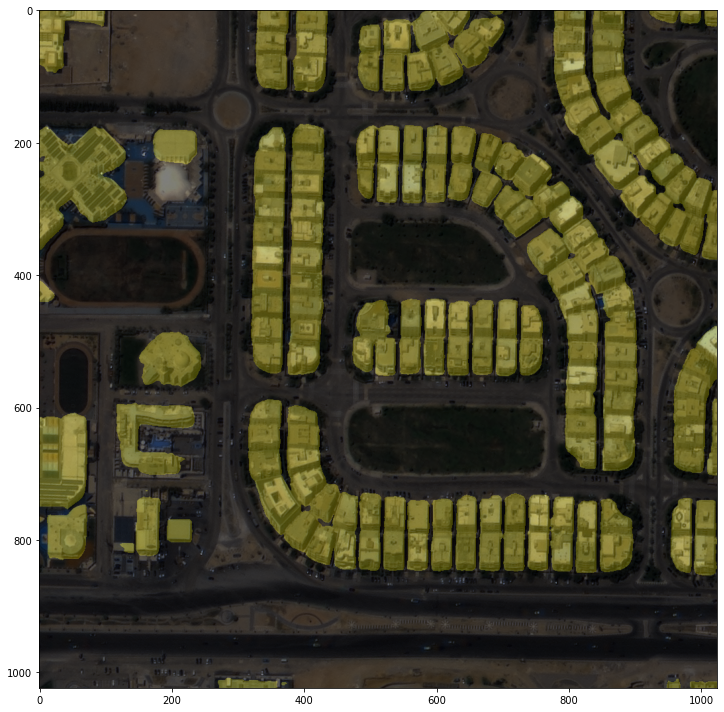

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


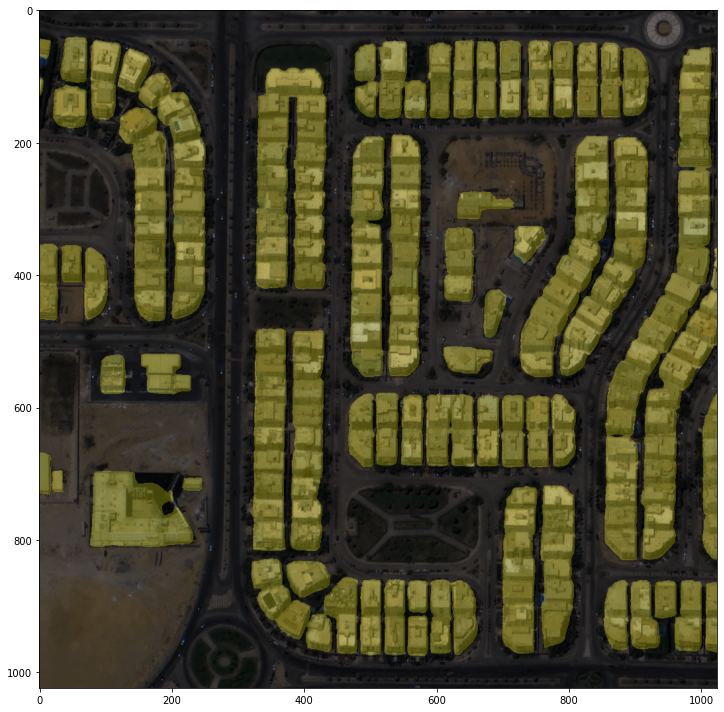

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


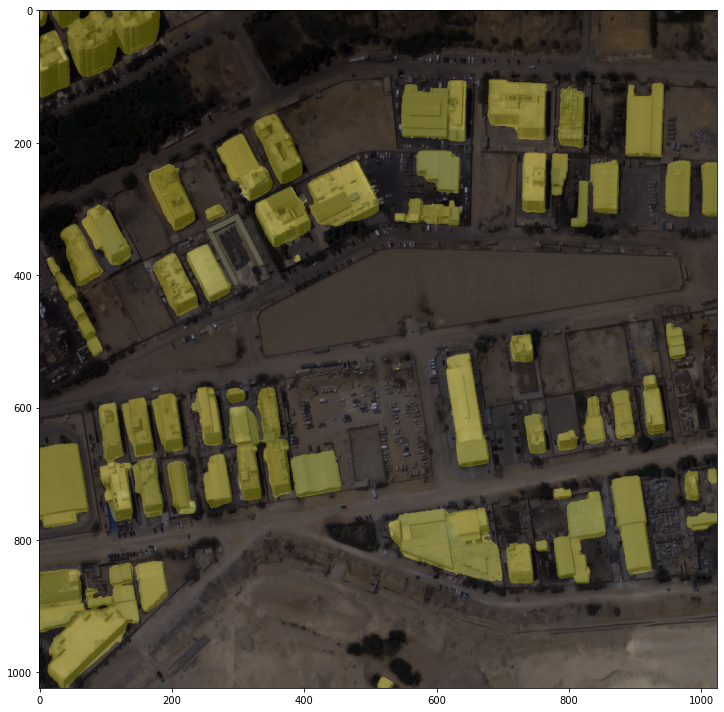

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00697_PS3_K3A_NIA0277.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD04404_PS3_K3A_NIA0378.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


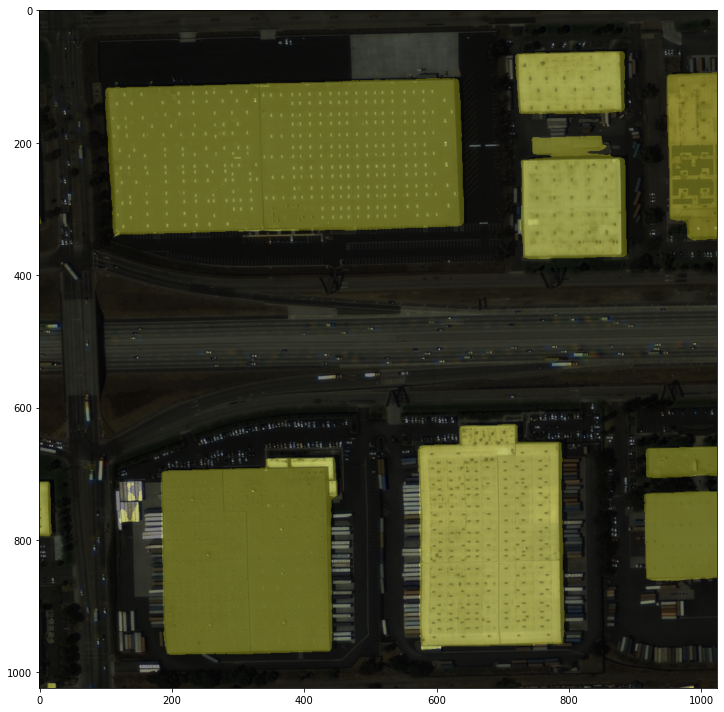

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD10921_PS3_K3A_NIA0389.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/OBJ00176_PS3_K3_NIA0081.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/OBJ01050_PS3_K3_NIA0089.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/OBJ03670_PS3_K3A_NIA0153.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

#### 네이버 지도 이미지로 테스트

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


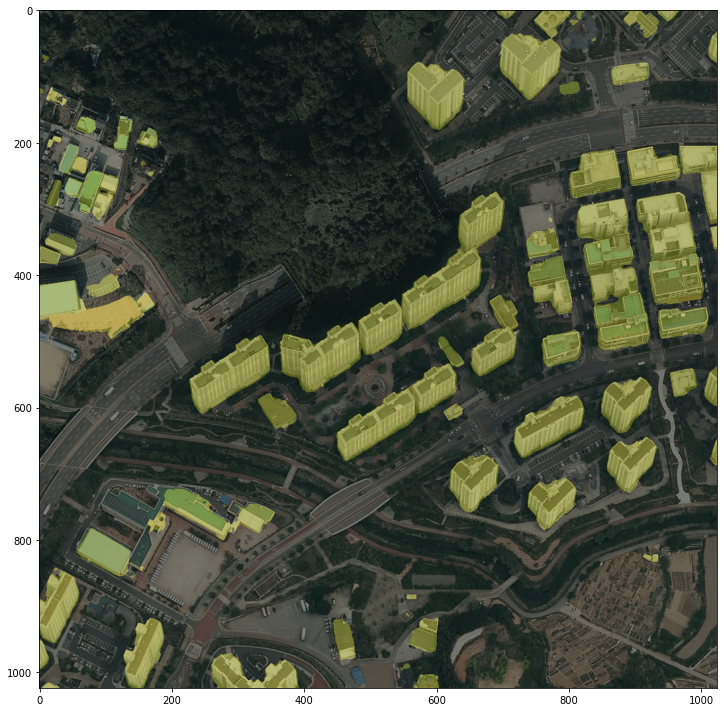

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


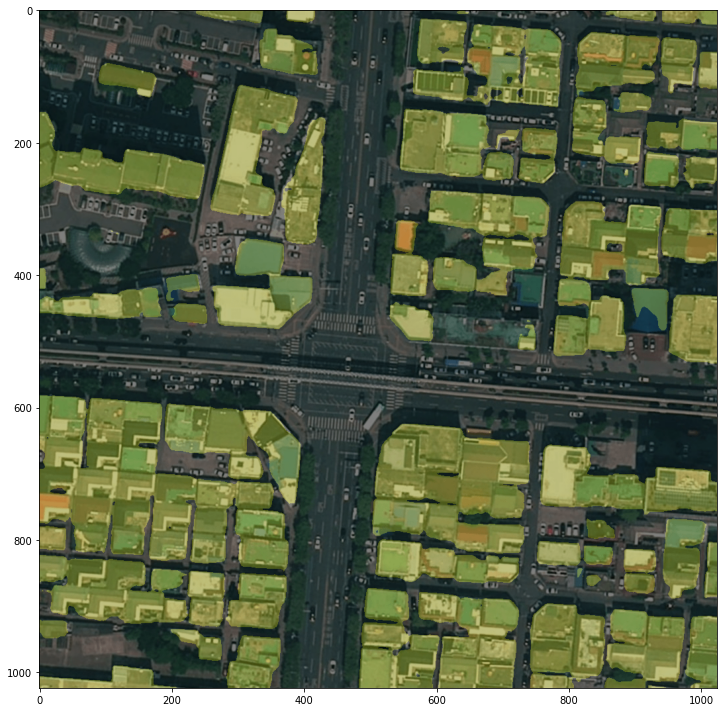

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0002.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)